In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from torch.utils.tensorboard import SummaryWriter






In [2]:
def create_curve(freq, ampl, freq_noise, ampl_noise, window_size):
    freq = random.gauss(freq, freq_noise) #add noise to frequency
    ampl = random.gauss(ampl, ampl_noise) #add noise to amplitude
    time = np.linspace(0, 10*np.pi, window_size)
    x = ampl*np.cos(freq*time)
    noise = np.random.normal(random.uniform(-1,0), random.uniform(0,1), window_size)
    x+=noise
    x = np.expand_dims(x, axis = 0) #expand to get 2d array (features, window length)
    x = np.expand_dims(x, axis = 0) #expand to get 3d array to store 2d elements
    #print(f"freq: {freq}, ampl:{ampl}")
    #plt.plot(time, x[0,0,:])
    #plt.show()
    
    return x

def create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size):
    
    X_data_class_1_domain_1 = create_curve(frequencies[0], amplitudes[0], freq_noise, ampl_noise, window_size)
    X_data_class_2_domain_1 = create_curve(frequencies[1], amplitudes[1], freq_noise, ampl_noise, window_size)
    X_data_class_1_domain_2 = create_curve(frequencies[2], amplitudes[2], freq_noise, ampl_noise, window_size)
    X_data_class_2_domain_2 = create_curve(frequencies[3], amplitudes[3], freq_noise, ampl_noise, window_size)
    
    
    for i in range(n-1):
        X_data_class_1_domain_1 = np.concatenate((X_data_class_1_domain_1, create_curve(frequencies[0], amplitudes[0], freq_noise, ampl_noise, window_size)), axis = 0) 
        X_data_class_2_domain_1 = np.concatenate((X_data_class_2_domain_1, create_curve(frequencies[1], amplitudes[1], freq_noise, ampl_noise, window_size)), axis = 0)
        X_data_class_1_domain_2 = np.concatenate((X_data_class_1_domain_2, create_curve(frequencies[2], amplitudes[2], freq_noise, ampl_noise, window_size)), axis = 0)
        X_data_class_2_domain_2 = np.concatenate((X_data_class_2_domain_2, create_curve(frequencies[3], amplitudes[3], freq_noise, ampl_noise, window_size)), axis = 0)
        #print(i)
        #print(np.shape(X_data_class_1_domain_1))
        
    n_samples = np.shape(X_data_class_2_domain_1)[0]*2  
    
    y_data_class_1_domain_1 = np.asarray([0]*np.shape(X_data_class_1_domain_1)[0])
    y_data_class_2_domain_1 = np.asarray([1]*np.shape(X_data_class_2_domain_1)[0])
    y_data_class_1_domain_2 = np.asarray([0]*np.shape(X_data_class_1_domain_2)[0])
    y_data_class_2_domain_2 = np.asarray([1]*np.shape(X_data_class_2_domain_2)[0])
    
    X_data_source = np.concatenate((X_data_class_1_domain_1, X_data_class_2_domain_1), axis = 0)
    y_data_source = np.concatenate((y_data_class_1_domain_1, y_data_class_2_domain_1), axis = 0)
    X_data_target = np.concatenate((X_data_class_1_domain_2, X_data_class_2_domain_2), axis = 0)
    y_data_target = np.concatenate((y_data_class_1_domain_2, y_data_class_2_domain_2), axis = 0)
    
    
    X_data_source = torch.from_numpy(X_data_source)
    y_data_source = torch.from_numpy(y_data_source)
    X_data_target = torch.from_numpy(X_data_target)
    y_data_target = torch.from_numpy(y_data_target)
    
    return n_samples, X_data_source, y_data_source, X_data_target, y_data_target
"""
#TEST
frequencies = [1,4,1.4,3.6]
amplitudes = [6,2,5,4]
freq_noise = 0.3
ampl_noise = 2
window_size = 1000
n_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
"""

'\n#TEST\nfrequencies = [1,4,1.4,3.6]\namplitudes = [6,2,5,4]\nfreq_noise = 0.3\nampl_noise = 2\nwindow_size = 1000\nn_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)\n'

In [3]:
class Dataset_Dummy_Source_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,1.9,3.1]#[1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5#0.3
        ampl_noise = 2
        window_size = 1000
        self.n_samples, self.x_data, self.y_data, _, _ = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class Dataset_Dummy_Target_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,1.9,3.1]#[1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5#0.3
        ampl_noise = 2
        window_size = 1000
        self.n_samples, _, _, self.x_data, self.y_data = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [4]:
#dataloader

dataset_source = Dataset_Dummy_Source_Window()

# define train/val dimensions
train_size_source = int(0.8 * len(dataset_source))
validation_size_source = len(dataset_source) - train_size_source

training_dataset_source, validation_dataset_source = torch.utils.data.random_split(dataset_source, [train_size_source, validation_size_source])
batch_size = 64
train_loader_source = DataLoader(dataset=training_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_source = DataLoader(dataset=validation_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)





dataset_target = Dataset_Dummy_Target_Window()

# define train/val dimensions
train_size_target = int(0.8 * len(dataset_target))
validation_size_target = len(dataset_target) - train_size_target

training_dataset_target, validation_dataset_target = torch.utils.data.random_split(dataset_target, [train_size_target, validation_size_target])
batch_size = 64
train_loader_target = DataLoader(dataset=training_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_target = DataLoader(dataset=validation_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

source_loader = {}
source_loader["train"] = train_loader_source
source_loader["val"] = validation_loader_source

target_loader = {}
target_loader["train"] = train_loader_target
target_loader["val"] = validation_loader_target

In [256]:
class CNN(nn.Module):
    def __init__(self, input_size, input_fc_size, hidden_fc_size_1, hidden_fc_size_2, output_size):
        super(CNN, self).__init__()
        
        """
        formula [(W−K+2P)/S]+1.
        """
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=100, stride=1)#input: 1000
        self.conv2 = nn.Conv1d(64,32,kernel_size=10, stride = 1, padding=1)#input: [(1000-100+2*0)/1]+1 = 901
        self.batch1 =nn.BatchNorm1d(32)#input: [(901-10+2*1)/1]+1 = 894
        self.conv3 = nn.Conv1d(32,32,kernel_size=5, stride = 1, padding=1) #input:894
        self.batch2 =nn.BatchNorm1d(32)#input: [(894-5+2*1)/1]+1 = 892
        self.fc1 = nn.Linear(input_fc_size, hidden_fc_size_1)
        self.fc2 = nn.Linear(hidden_fc_size_1, hidden_fc_size_2)
        self.fc3 = nn.Linear(hidden_fc_size_2, output_size)

        self.init_weights()
        
    def forward(self, x):
        x = self.conv1(x) #conv1
        x = F.relu(x)
        x = self.conv2(x) #conv2
        x = self.batch1(x) #batch1
        x = F.relu(x)
        x = self.conv3(x) #conv3
        x = self.batch2(x) #batch2
        x = F.relu(x)
        x = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        x_fc1 = self.fc1(x)
        x_fc1 = F.relu(x_fc1)
        x_fc2 = self.fc2(x_fc1)
        x_fc2 = F.relu(x_fc2)
        x_fc3 = self.fc3(x_fc2)
        x_fc3 = F.relu(x_fc3)
        
        return x_fc1, x_fc2, x_fc3
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            

In [257]:
input_size = 1
input_fc_size = 32*892 #25*40 
hidden_fc_size_1 = 100
hidden_fc_size_2 = 3
output_size = 2



model = CNN(input_size, input_fc_size, hidden_fc_size_1, hidden_fc_size_2, output_size)


print(model)


CNN(
  (conv1): Conv1d(1, 64, kernel_size=(100,), stride=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(10,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=28544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=2, bias=True)
)


In [258]:
"""
#from mmd_loss import MMD_loss
class MMD_loss(nn.Module):
    def __init__(self, fix_sigma = None, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = fix_sigma
        return
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if torch.is_tensor(fix_sigma):
            bandwidth_list = fix_sigma
        else:
                bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
                bandwidth /= kernel_mul ** (kernel_num // 2)
                bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):

        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss
    
"""

#from mmd_loss import MMD_loss
class MMD_loss(nn.Module):
    def __init__(self, fix_sigma):
        super(MMD_loss, self).__init__()
        self.fix_sigma = fix_sigma
        return
    def gaussian_kernel(self, source, target, fix_sigma):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        kernel_val = [torch.exp(-L2_distance / sigma) for sigma in self.fix_sigma]
        return sum(kernel_val)

    def forward(self, source, target):

        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [259]:

def forward(model, data, labels_source, labels_target, criterion, MMD_loss_calculator, GAMMA):
        

        x_fc1, x_fc2, x_fc3 = model(data.float())
        batch_size = len(labels_source)
        # cross-entropy loss
        
        source_out = x_fc2[:batch_size, :]
        target_out = x_fc2[batch_size:, :]
        source_pred = x_fc3[:batch_size, :]
        target_pred = x_fc3[batch_size:, :]
        
        #CE loss
        source_ce_loss = criterion(source_pred, labels_source)
        target_ce_loss = criterion(target_pred, labels_target)

        # MMD Loss FC
        mmd_loss = MMD_loss_calculator.forward(source_out, target_out)
        
        #total loss
        loss = source_ce_loss + GAMMA * mmd_loss
        

        #collect information about labels, predictions
        n_correct_source = 0
        n_correct_target = 0
        n_samples_source = 0
        n_samples_target = 0
        
        
        # plot list
        class_0_source = np.empty((0,3))
        class_1_source = np.empty((0,3))
        class_0_target = np.empty((0,3))
        class_1_target = np.empty((0,3))
        
        
        #for each element in batch check if prediction is correct and collect total and correct predictions and labels
        for i in range(len(labels_source)):
            label_source = labels_source[i]
            output_source = torch.argmax(source_pred[i])
            if label_source == output_source:
                n_correct_source+=1
            n_samples_source+=1
            
            if label_source == 0:
                class_0_source = np.append(class_0_source, np.expand_dims(source_out[i,:].detach().numpy(), axis = 0), axis = 0)
            elif label_source == 1:
                class_1_source = np.append(class_1_source, np.expand_dims(source_out[i,:].detach().numpy(), axis = 0), axis = 0)
                
        acc_total_source = 100.0 * n_correct_source / n_samples_source
            
        for i in range(len(labels_target)):
            label_target = labels_target[i]
            output_target = torch.argmax(target_pred[i])
            if label_target == output_target:
                n_correct_target+=1
            n_samples_target+=1
                
            if label_target == 0:
                class_0_target = np.append(class_0_target, np.expand_dims(target_out[i,:].detach().numpy(), axis = 0), axis = 0)
            elif label_target == 1:
                class_1_target = np.append(class_1_target, np.expand_dims(target_out[i,:].detach().numpy(), axis = 0), axis = 0)

            

        acc_total_target = 100.0 * n_correct_target / n_samples_target

        
        return loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source, class_1_source, class_0_target, class_1_target

   


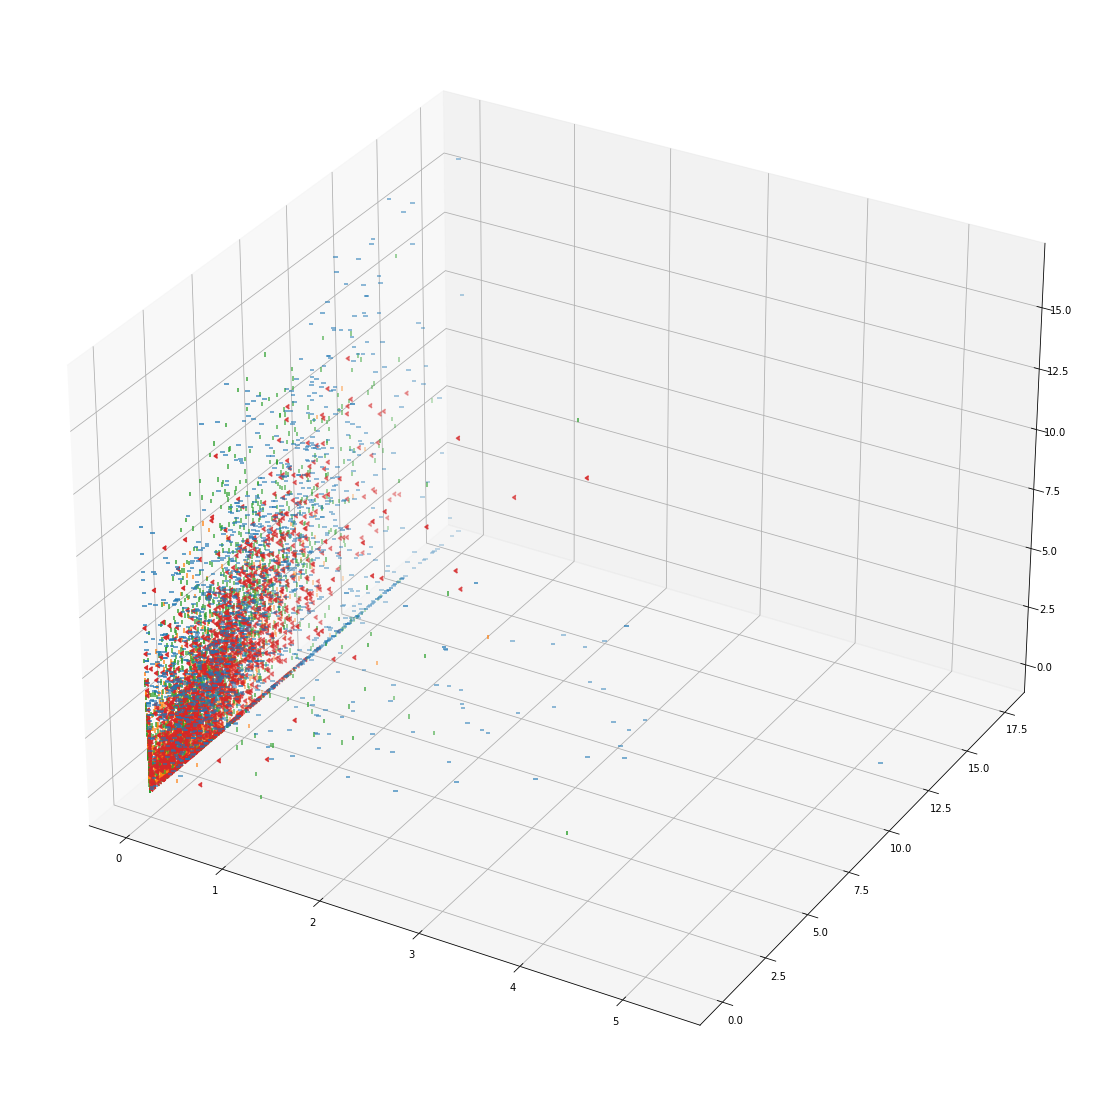

Epoch 1/10 successfull
Epoch 2/10 successfull


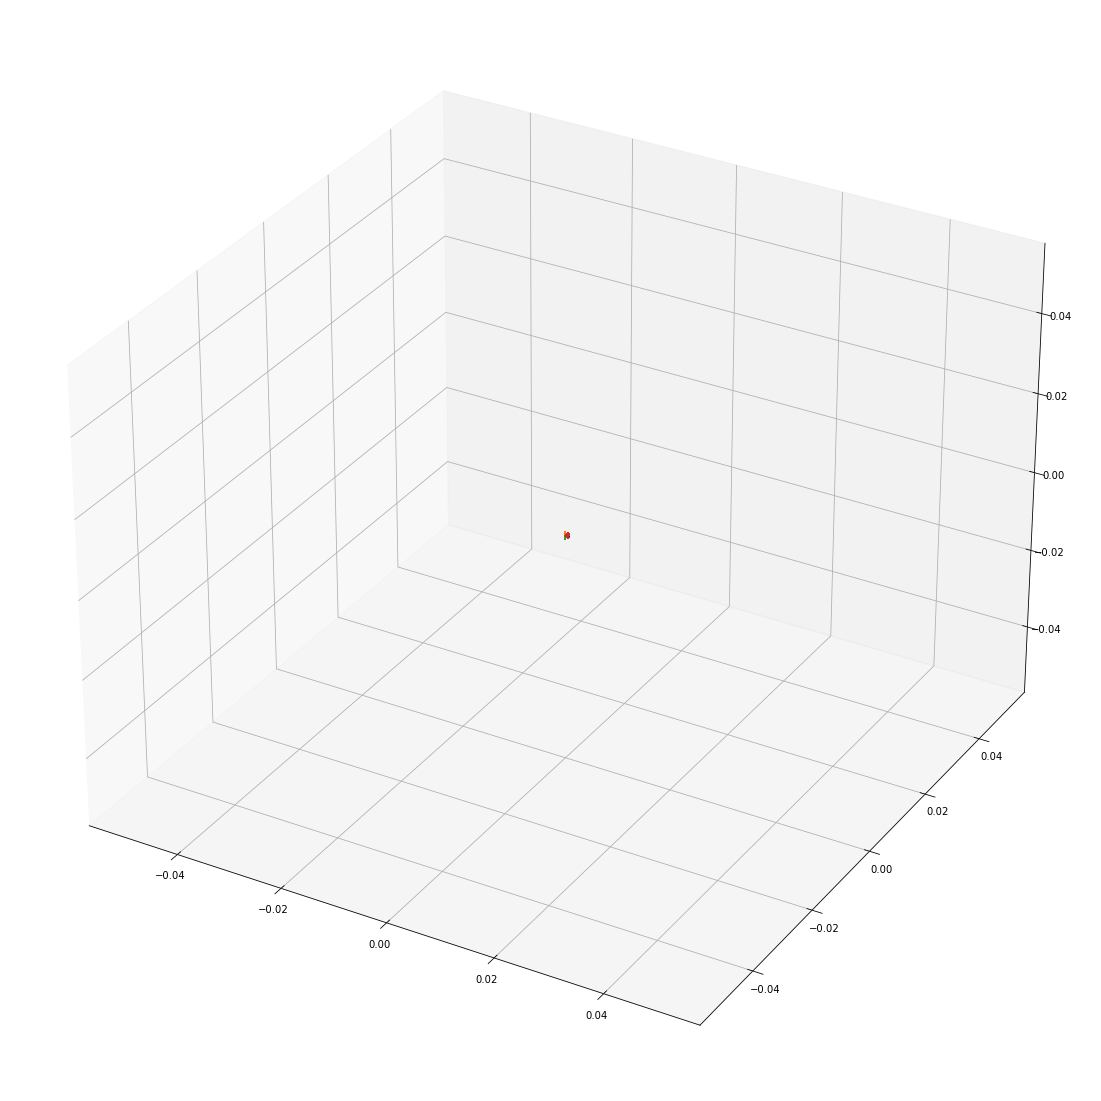

Epoch 3/10 successfull
Epoch 4/10 successfull


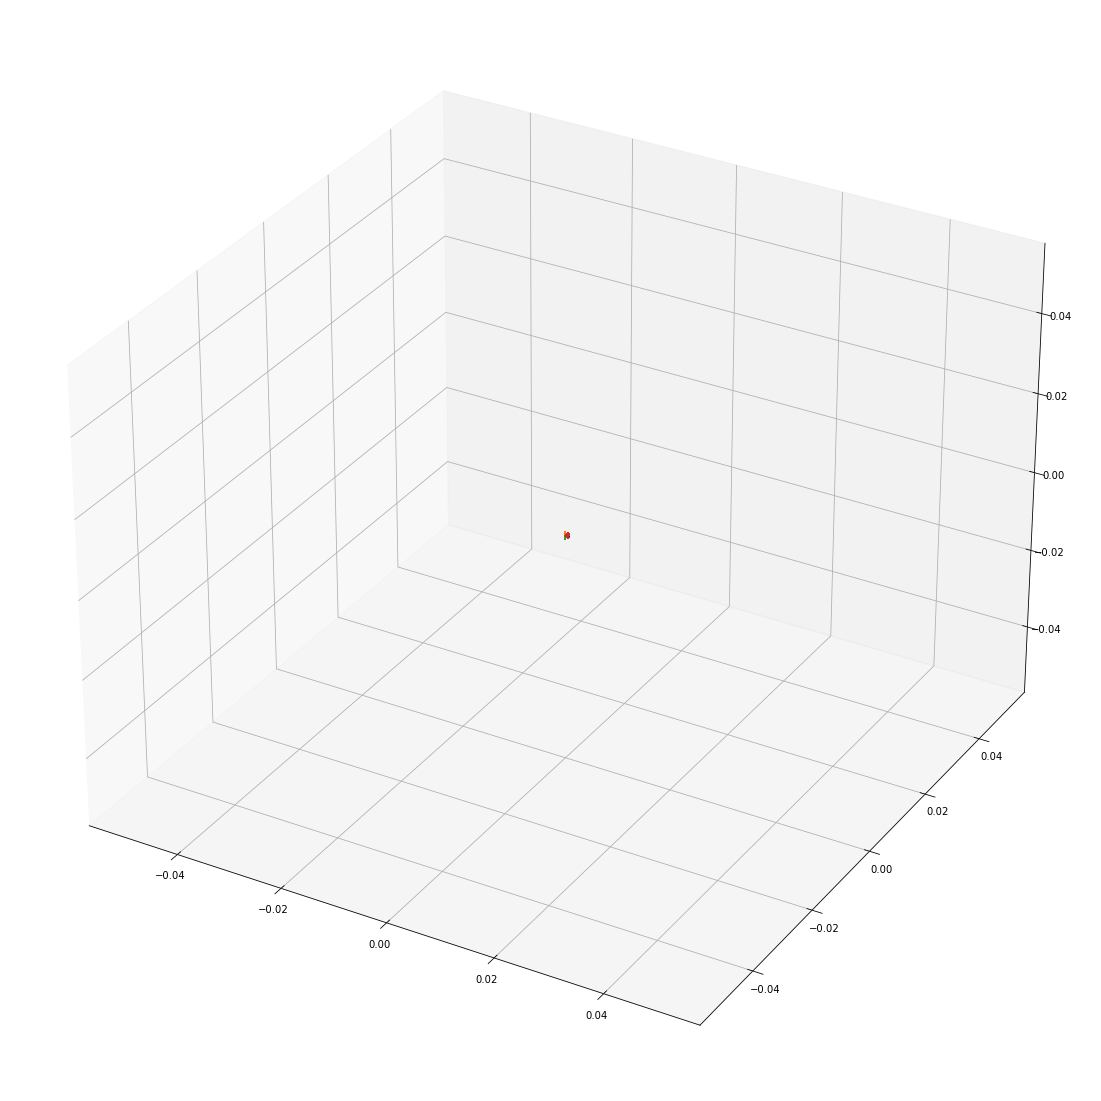

KeyboardInterrupt: 

In [260]:

writer_graph = SummaryWriter('runs/Dataloader2/graph')
writer_source_train = SummaryWriter('runs/Dataloader2/source_train')
writer_target_train = SummaryWriter('runs/Dataloader2/target_train')
writer_source_val = SummaryWriter('runs/Dataloader2/source_val')
writer_target_val = SummaryWriter('runs/Dataloader2/target_val')

writer_source = {}
writer_source["train"] = writer_source_train
writer_source["val"] = writer_source_val

writer_target = {}
writer_target["train"] = writer_target_train
writer_target["val"] = writer_target_val

#define training params
num_epochs = 10
learning_rate = 0.1#0.008
GAMMA = 2.5  # 1000 more weight to transferability
SIGMA = torch.tensor([1,2,4,8,16],dtype=torch.float64)

#define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
MMD_loss_calculator = MMD_loss(fix_sigma = SIGMA)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


#collect CE-, MMD-Loss and Accuracy for each batch
loss_collected = 0
target_ce_loss_collected = 0
mmd_loss_collected = 0

mmd_loss_lst = {}
mmd_loss_lst["train"] = []
mmd_loss_lst["val"] = []

ce_loss_source_lst = {}
ce_loss_source_lst["train"] = []
ce_loss_source_lst["val"] = []

ce_loss_target_lst = {}
ce_loss_target_lst["train"] = []
ce_loss_target_lst["val"] = []

accuracy_source_lst = {}
accuracy_source_lst["train"] = []
accuracy_source_lst["val"] = []

accuracy_target_lst = {}
accuracy_target_lst["train"] = []
accuracy_target_lst["val"] = []



phases = ["val", "train"]
# Train and Validate the model
for epoch in range(num_epochs):
    #plot mmd
    class_0_source_collect = np.empty((0,3))
    class_1_source_collect = np.empty((0,3))
    class_0_target_collect = np.empty((0,3))
    class_1_target_collect = np.empty((0,3))
    
    loss_collected = 0
    acc_collected = 0
    

    
    for phase in phases:
        iter_loader_source = iter(source_loader[phase])
        iter_loader_target = iter(target_loader[phase])
        
        #get number of batches of train loader
        assert len(source_loader[phase]) == len(target_loader[phase])
        len_loader = len(source_loader[phase])
        
        
        mmd_loss_collected = 0
        source_ce_loss_collected = 0
        target_ce_loss_collected = 0
        acc_total_source_collected = 0
        acc_total_target_collected = 0
        
        for i in range(len_loader):

            ########Forward pass########
            data_source, labels_source = iter_loader_source.next() #batch_size number of windows and labels from source domain
            data_target, labels_target = iter_loader_target.next() #batch_size number of windows from target domain
            data = torch.cat((data_source, data_target), dim=0) #concat the windows to 2*batch_size number of windows
            
            #get number of samples per batch
            assert len(labels_source) == len(labels_target)
            batch_size = len(labels_source) #take length of shorter dataoader which is the one from source domain (reason:train, val split)
                        
            if phase == "val":
                
                model.train(False)
                
                with torch.no_grad():
                    _, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source, class_1_source, class_0_target, class_1_target = forward(model, data, labels_source, labels_target, criterion, MMD_loss_calculator, GAMMA)
                    
                    mmd_loss_collected += mmd_loss
                    source_ce_loss_collected += source_ce_loss
                    target_ce_loss_collected += target_ce_loss
                    acc_total_source_collected += acc_total_source
                    acc_total_target_collected += acc_total_target
                    
                    # collect plot values
                    class_0_source_collect = np.append(class_0_source_collect, class_0_source, axis = 0)
                    class_1_source_collect = np.append(class_1_source_collect, class_1_source, axis = 0)
                    class_0_target_collect = np.append(class_0_target_collect, class_0_target, axis = 0)
                    class_1_target_collect = np.append(class_1_target_collect, class_1_target, axis = 0)
                    
                    
            
            elif phase == "train":
                #for param in model.parameters():
                #    print(param)
                model.train(True)
                                
                ########Forward pass########
                loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward(model, data, labels_source, labels_target, criterion, MMD_loss_calculator, GAMMA)
                
                mmd_loss_collected += mmd_loss.detach()
                source_ce_loss_collected += source_ce_loss.detach()
                target_ce_loss_collected += target_ce_loss.detach()
                acc_total_source_collected += acc_total_source
                acc_total_target_collected += acc_total_target

                ########Backward pass########
                optimizer.zero_grad()
                loss.backward()
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1000000000)
                optimizer.step()
                
                
        #plot
        if phase == "val" and (epoch ==0 or epoch ==2 or epoch == 4 or epoch ==6):

            fig = plt.figure()
            plt.gcf().set_size_inches((20, 20)) 
            ax = fig.add_subplot(projection='3d')

            m = [1,2,3,4]
            data = [class_0_source_collect, class_1_source_collect, class_0_target_collect, class_1_target_collect]
            for i in range(4):
                ax.scatter(data[i][:,0], data[i][:,1], data[i][:,2], marker=m[i])
            
            plt.show()
            fig.savefig(f"no_mmd_epoch{epoch}")       
                
                
    
        running_ce_loss_source = source_ce_loss_collected / len_loader
        running_ce_loss_target = target_ce_loss_collected / len_loader
        
        running_acc_source = acc_total_source_collected / len_loader
        running_acc_target = acc_total_target_collected / len_loader
        
        running_mmd_loss = mmd_loss_collected/ len_loader

    
        

        ce_loss_source_lst[phase].append(running_ce_loss_source)
        ce_loss_target_lst[phase].append(running_ce_loss_target)
        writer_source[phase].add_scalar(f'CE-Loss', running_ce_loss_source, epoch)
        writer_target[phase].add_scalar(f'CE-Loss', running_ce_loss_target, epoch)
        
        accuracy_source_lst[phase].append(running_acc_source)
        accuracy_target_lst[phase].append(running_acc_target)
        writer_source[phase].add_scalar(f'Accuracy', running_acc_source, epoch)
        writer_target[phase].add_scalar(f'Accuracy', running_acc_target, epoch)
        
        mmd_loss_lst[phase].append(running_mmd_loss)
        writer_source[phase].add_scalar(f'MMD-Loss', running_mmd_loss, epoch)
            

    print(f"Epoch {epoch+1}/{num_epochs} successfull")





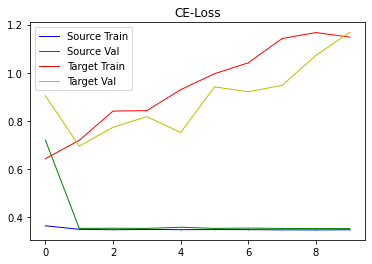

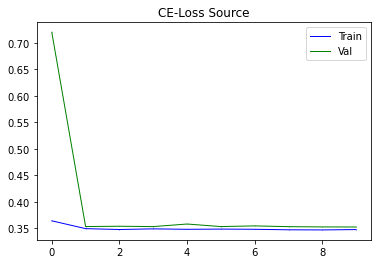

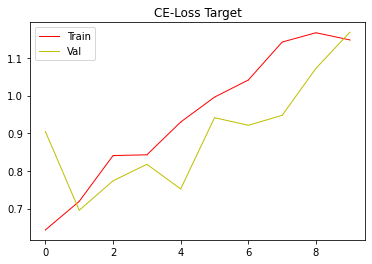

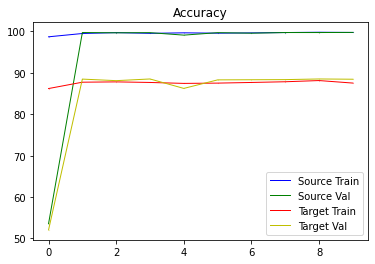

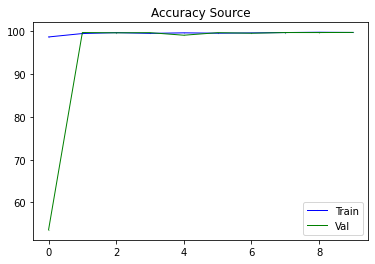

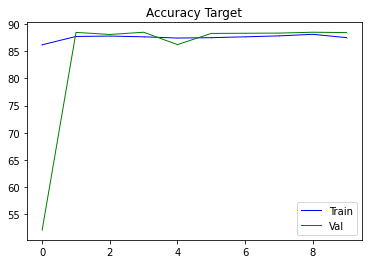

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

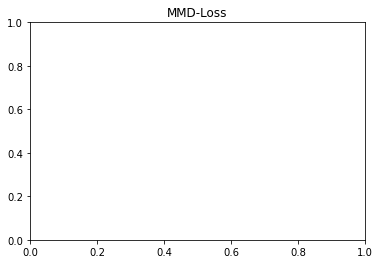

In [250]:
fig1 = plt.figure()
plt.title('CE-Loss')
plt.plot(ce_loss_source_lst['train'], 'bo-', label = 'Source Train', linewidth=1,markersize=0.1)
plt.plot(ce_loss_source_lst['val'], 'go-', label = 'Source Val', linewidth=1,markersize=0.1)
plt.plot(ce_loss_target_lst['train'], 'ro-', label = 'Target Train', linewidth=1,markersize=0.1)
plt.plot(ce_loss_target_lst['val'], 'yo-', label = 'Target Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('CE_Loss')

fig2 = plt.figure()
plt.title('CE-Loss Source')
plt.plot(ce_loss_source_lst['train'], 'bo-', label = 'Train', linewidth=1,markersize=0.1)
plt.plot(ce_loss_source_lst['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)

plt.legend()
plt.show()
fig2.savefig('CE_Loss_Source')

fig3 = plt.figure()
plt.title('CE-Loss Target')
plt.plot(ce_loss_target_lst['train'], 'ro-', label = 'Train', linewidth=1,markersize=0.1)
plt.plot(ce_loss_target_lst['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('CE_Loss_Target')

fig2 = plt.figure()
plt.title('Accuracy')
plt.plot(accuracy_source_lst['train'], 'bo-', label = 'Source Train', linewidth=1,markersize=0.1)
plt.plot(accuracy_source_lst['val'], 'go-', label = 'Source Val', linewidth=1,markersize=0.1)
plt.plot(accuracy_target_lst['train'], 'ro-', label = 'Target Train', linewidth=1,markersize=0.1)
plt.plot(accuracy_target_lst['val'], 'yo-', label = 'Target Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('Accuracy')

fig3 = plt.figure()
plt.title('Accuracy Source')
plt.plot(accuracy_source_lst['train'], 'bo-', label = 'Train', linewidth=1,markersize=0.1)
plt.plot(accuracy_source_lst['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('Accuracy_Source')

fig4 = plt.figure()
plt.title('Accuracy Target')
plt.plot(accuracy_target_lst['train'], 'bo-', label = 'Train', linewidth=1,markersize=0.1)
plt.plot(accuracy_target_lst['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig4.savefig('Accuracy_Target')

fig3 = plt.figure()
plt.title('MMD-Loss')
plt.plot(mmd_loss_lst['train'], 'bo-', label = 'MMD Train', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_lst['val'], 'go-', label = 'MMD Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('MMD_Loss')